# Data extraction from trace
This notebook aims to take the `.pcap` files generated from the trace and use those to create a csv file that contains the features and labels to input to our classifier.

In [34]:
from scapy.all import *
from scapy.utils import rdpcap
import pandas as pd
import os
from typing import List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats


In [35]:
Packet = Tuple[int, float, int]
"""
represents a packet by its:
- IN/OUT nature (IN == to client == 1) (OUT == to server == 0)
- timestamp
- packet length
"""
TraceTuple = Tuple[str, int, int, int]
"""
stores the trace name along with its informations for data cleaning:
- trace name (the filename)
- trace index (identifies traces with same date-hour)
- trace cell ID (the id of the queried cell)
- trace lenghth
"""
dummy=1

## Client-Server interaction
We first recall the implementation of client server interaction. Indeed, this one is described in `handout_project_secretstroll.pdf`. Taking a look at implementation of `server.py` and `client.py`, we must make key observations:
* When querying the server, the client will sequentially:
  * retrieve the list of PoI (**which can pretty much vary in size between cells**)
  * the client then iterates through each PoI -> **no shuffling** is performed at any step, this lets us suppose that 2 queries for the same cell will produce a **same sequence of queries for the PoI infos** to the server.
  * they make a query to retrieve the PoI infos for each. We must note that the **number of PoI ratings may vary a lot from a PoI to another**, making a PoI info response trace pretty unique.
* When receiving client's queries, the server will:
  * return the list of around PoI (as explained with a probably preserved order between queries). Here comes a pretty nasty trick: the **implementation given seems to not take into account the variety of possible queries**. Indeed, independently of the queries `types` of PoI (the user subscription), the server will in any case answer by **giving the full list of PoI in the cell** (`records = PoI.query.filter_by(grid_id=cell_id).all()`). This should not happen under the functionnalities described in the handout, but we'll make an adapted training set that will not need to test different types of queries, only the cell ID will vary. If we were to make the attack under fully functionnal system, we'd make a way bigger training set considering the different subscription traces and their combinations.
  * when queried on the info for the point of interest, makes an answer that contains all its information. Note that the **number of ratings associated to it which has the most significant impact on the trace**.

Considering this, we will now be able to analyse our received data.

## Received data
First, the data we receive is in the form of `.pcap` files. Those were filtered to contain only (see `capture.sh`):
* **TCP packets**, other protocols packets are considered not relevant to the application (ARP requests, DNS stuff etc...)
* **packets that have a TCP payload**. Basically all TCP ACKs and other controls packets are filtered and not considered as those depend on the networking related traffic and will noise the core of the application layer generated fingerprint

From those packets, can be retrieved:
* **Ethernet header** (14 bytes, bytes 0 to 13). Those will probably not be relevant for us as depending on the inner Docker networking (or any used LAN environment)
* **IP headers** (20 bytes, bytes 14 to 33). Those bytes mostly contain the routing information (source IP, destination IP, routing flags, etc...). The main information we may want to retrieve from this is the direction of the packets we observe (query or response).
* **TCP headers** (20 bytes, bytes 34 to 53). These bytes contain the stream informations (sequence and ACK indexes, timestamps, payload size, etc...). These can all be very useful to distinguish a trace from another by the client-server interaction implementation.
* **TLS headers** (10 bytes, bytes 54 to 63). These bytes contains some informations about the version and inner data. the bytes 59 to 63 are the first bytes of the encrypted data which is not recorded as it is not meaningful for us. Indeed the headers already contain the length meta-data and we will not get much more from the correctly encrypted payload (unless we make cryptographic attacks which does not seem reasonnable as the TLS1.2 version is used here).

From this, we are able to define the data we'll want to keep and output to our classifier.

## Desired data model
First, we must decide on the way we'll represent our data as features.

Label (cell_id queried) | Trace (packet list generated)
:---: | :---: 
1 | `[pkt1,pkt2,...]`

We must now decide on a way to represent our packets. To reduce the amount of input and redundant information, we can remove the IP addresses as there will only be 2 of them, either going in or out.

## Extraction from pcap file
### Data cleaning
We first take a look at the the retrieved traces. We will see if some badly saved traces are present and decide if they should be removed.

To do so, we have defined the `TraceTuple` type that identifies a trace. It also contains the length of this trace, this will be our main measure of healthiness of the capture: we expect our traces to differ but would like to detect huge outliers that might come from a networking issue during the capture.

In [36]:
def from_file_to_pkt_count(root: str, file: str) -> int:
    """Memory efficient function to return the number of packets in a pcap file without loading the full file in memory. Also makes sure we can iterate through all packets of a trace"""
    size = 0
    # if the pcap file is corrupted, we should have an error in the file reading there
    with PcapReader("{}/{}".format(root, file)) as pcap:
        for pkt in pcap:
            size += 1
    return size


# exemple
from_file_to_pkt_count("traces", "trace_01_04_14h_cell_69.pcap")


435

In [37]:
def from_file_to_trace_tuple(root: str, file: str) -> TraceTuple:
    """Allows us to read a file and produce our desired TraceTuple"""
    if not file.endswith(".pcap"):
        raise ValueError("give only .pcap files as input")
    trace_name = file.removesuffix(".pcap").split("_")
    # allow us to uniquely index uniquely any trace by an integer
    trace_index = (
        int(trace_name[1]) * 10000
        + int(trace_name[2]) * 100
        + int(trace_name[3].removesuffix("h"))
    )
    cell_index = int(trace_name[5])
    return file, trace_index, cell_index, from_file_to_pkt_count(root, file)


# exemple
trace_tuple = from_file_to_trace_tuple("traces", "trace_01_04_08h_cell_1.pcap")
trace_tuple


('trace_01_04_08h_cell_1.pcap', 10408, 1, 461)

In [38]:
def read_all_traces() -> List[TraceTuple]:
    """Returns a list of tuple describing all traces"""
    for root, dirs, files in os.walk("traces"):
        pcap_files = list(filter(lambda f: f.endswith(".pcap"), files))
        print("{} traces in the folder".format(len(pcap_files)))
        return list(map(lambda f: from_file_to_trace_tuple(root, f), pcap_files))


all_traces = read_all_traces()


600 traces in the folder


We then create a pandas `DataFrame` to store our data

In [39]:
data = {
    "name": list(map(lambda t: t[0], all_traces)),
    "index": list(map(lambda t: t[1], all_traces)),
    "cell_id": list(map(lambda t: t[2], all_traces)),
    "packet_list_len": list(map(lambda t: t[3], all_traces)),
}
traces = pd.DataFrame(data)
traces


,name,index,cell_id,packet_list_len
0,trace_01_04_08h_cell_1.pcap,10408,1,461
1,trace_01_04_08h_cell_10.pcap,10408,10,137
2,trace_01_04_08h_cell_100.pcap,10408,100,479
3,trace_01_04_08h_cell_11.pcap,10408,11,499
4,trace_01_04_08h_cell_12.pcap,10408,12,379
...,...,...,...,...
595,trace_31_03_20h_cell_95.pcap,310320,95,274
596,trace_31_03_20h_cell_96.pcap,310320,96,417
597,trace_31_03_20h_cell_97.pcap,310320,97,488
598,trace_31_03_20h_cell_98.pcap,310320,98,112


Let us have a look at the basic statistics of the dataframe:

In [48]:
traces.groupby("cell_id").describe()

index                                                           \
        count          mean            std      min       25%      50%   
cell_id                                                                  
1         6.0  62063.000000  121685.902115  10408.0  10411.25  10413.0   
2         6.0  62063.000000  121685.902115  10408.0  10411.25  10413.0   
3         6.0  62063.000000  121685.902115  10408.0  10411.25  10413.0   
4         6.0  62063.000000  121685.902115  10408.0  10411.25  10413.0   
5         6.0  62063.000000  121685.902115  10408.0  10411.25  10413.0   
...       ...           ...            ...      ...       ...      ...   
96        6.0  62063.166667  121686.310143  10408.0  10411.25  10413.0   
97        6.0  62063.166667  121686.310143  10408.0  10411.25  10413.0   
98        6.0  62063.166667  121686.310143  10408.0  10411.25  10413.0   
99        6.0  62063.166667  121686.310143  10408.0  10411.25  10413.0   
100       6.0  62063.166667  121686.310143  10408.0  10411.25  10413.0   

                           packet_list_len                                \
             75%       max           count        mean        std    min   
cell_id                                                                    
1        17914.0  310319.0             6.0  481.333333  67.414143  425.0   
2        17914.0  310319.0             6.0  424.166667  35.295420  381.0   
3        17914.0  310319.0             6.0  563.500000  25.232915  526.0   
4        17914.0  310319.0             6.0  103.333333  10.269697   90.0   
5        17914.0  310319.0             6.0  316.500000  13.924798  299.0   
...          ...       ...             ...         ...        ...    ...   
96       17914.0  310320.0             6.0  432.333333  25.562994  413.0   
97       17914.0  310320.0             6.0  507.333333  32.426327  473.0   
98       17914.0  310320.0             6.0  109.000000  11.558547   86.0   
99       17914.0  310320.0             6.0  477.333333  36.340978  419.0   
100      17914.0  310320.0             6.0  468.000000  35.575272  402.0   

                                       
            25%    50%     75%    max  
cell_id                                
1        431.00  455.0  519.50  589.0  
2        403.00  416.0  447.75  475.0  
3        546.75  576.0  580.50  584.0  
4         99.25  102.0  105.50  121.0  
5        308.25  314.0  325.00  337.0  
...         ...    ...     ...    ...  
96       416.25  418.0  446.75  473.0  
97       485.00  502.5  520.00  561.0  
98       110.50  112.5  115.25  117.0  
99       465.50  480.5  491.75  528.0  
100      464.50  474.0  488.00  504.0  

[100 rows x 16 columns]

We now want to make sure that no capture issue occured. The following boxplot allow us to see the distribution of the packet list length for the traces grouped by the cell_id that generated the trace.

We expect that traces generated by same cell_id can differ but remain in approximatley same order of magnitude: indeed, observing the client code, we see that the added noise that extends the length of the returned information for a PoI is a random up to a `noise_factor` of 10.

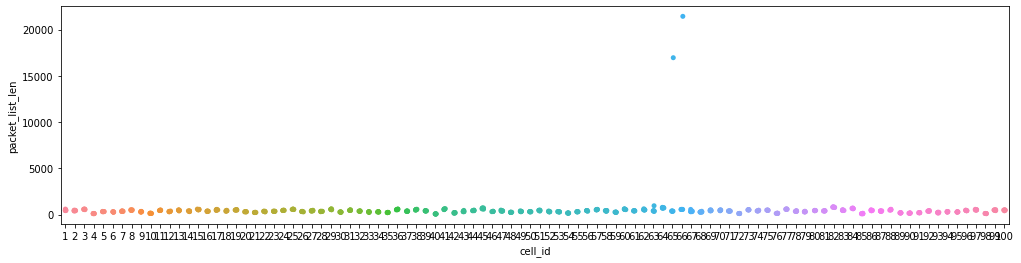

In [41]:
plt.figure(figsize=(17, 4))
strip = sns.stripplot(x=traces["cell_id"], y=traces["packet_list_len"])
plt.show()

In order to identify where do the observed outliers come from, we compute the Z-Score of the column. Basically, center and normalize our column's values and will identify the values that differ from the mean of more than 3 standard-deviations ($z>3$) which is a standard measure to detect huge outliers.

,name,index,cell_id,packet_list_len
362,trace_01_04_14h_cell_65.pcap,10414,65,16952
363,trace_01_04_14h_cell_66.pcap,10414,66,21424


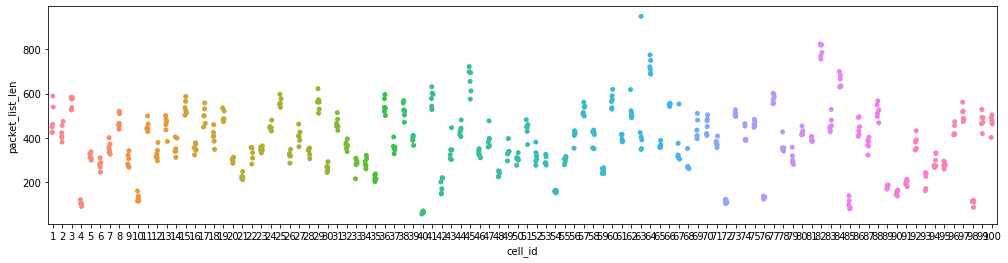

In [42]:
z = np.abs(stats.zscore(traces["packet_list_len"]))
outliers = traces[z > 3]
display(outliers)
filtered = traces[z < 3]
plt.figure(figsize=(17, 4))
strip = sns.stripplot(x=filtered["cell_id"], y=filtered["packet_list_len"])
plt.show()


These outliers come from the same capture and are issued by 2 successive queries. We suppose those are not meaningful and probably shows a connection issue from the capture. To have a fair training set and not reduce the signal generated by some cell traces, we decide to discard this trace and can make other captures to have consistent results.

In [43]:
selected_traces = traces[~traces["index"].isin(outliers["index"])]

### Data extraction
Now we are pretty confident we kept useful data only, we can